In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Dual Momentum Strategy: 

An Overview:

The Dual Momentum Strategy proposed by Gary Antonacci incorporates two distinct momentum concepts:

Relative Momentum: This aspect of momentum compares the performance of various assets relative to each other. For instance, in a universe of stocks and bonds, relative momentum would suggest investing in the asset that has performed better over a specific period.

Absolute Momentum: Also known as “time-series momentum,” absolute momentum compares the performance of an asset against its own historical performance. If the asset’s recent performance is positive compared to its longer-term performance, it is considered a good investment.

By combining these two momentum indicators, the Dual Momentum Strategy seeks to enhance returns while reducing drawdowns.

In [24]:
nifty50_ticker = "^NSEI"  # Nifty 50 index ticker
gold_ticker = "GLD"  # Gold ticker

nifty50_data = yf.download(nifty50_ticker, start="2018-01-01", end="2025-08-27")
gold_data = yf.download(gold_ticker, start="2018-01-01", end="2025-08-27")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [25]:
# Calculate the 200-day EMA for Nifty 50
nifty50_data['200_EMA'] = nifty50_data['Close'].ewm(span=200, adjust=False).mean()

# Calculate yearly returns for Nifty 50 and Gold
nifty50_data['Yearly_Return'] = nifty50_data['Close'].pct_change(252)
gold_data['Yearly_Return'] = gold_data['Close'].pct_change(252)

# Align gold data with Nifty 50 data
gold_data = gold_data.reindex(nifty50_data.index).fillna(method='ffill')

C:\Users\User\AppData\Local\Temp\ipykernel_7700\2002526985.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gold_data = gold_data.reindex(nifty50_data.index).fillna(method='ffill')


In [26]:
# Generate trading signals based on the updated strategy
nifty50_data['Signal'] = 0
nifty50_data.loc[(nifty50_data['Close'] > nifty50_data['200_EMA']) & 
                 (nifty50_data['Yearly_Return'] > gold_data['Yearly_Return']), 'Signal'] = 1  # Buy Nifty 50
nifty50_data.loc[nifty50_data['Signal'] == 0, 'Signal'] = -1  # Shift to Gold

In [27]:
# Calculate daily returns
nifty50_data['Nifty50_Returns'] = nifty50_data['Close'].pct_change()
gold_data['Gold_Returns'] = gold_data['Close'].pct_change()

# Calculate strategy returns
nifty50_data['Strategy_Returns'] = np.where(
    nifty50_data['Signal'] == 1, 
    nifty50_data['Nifty50_Returns'], 
    gold_data['Gold_Returns']
)

# Calculate cumulative returns (equity curve) for the strategy
nifty50_data['Strategy_Equity_Curve'] = (1 + nifty50_data['Strategy_Returns']).cumprod()

# Calculate Buy and Hold returns for Nifty 50
nifty50_data['Buy_Hold_Equity_Curve'] = (1 + nifty50_data['Nifty50_Returns']).cumprod()

In [28]:
# Calculate Drawdowns for Dual Momentum Strategy
nifty50_data['Strategy_Peak'] = nifty50_data['Strategy_Equity_Curve'].cummax()
nifty50_data['Strategy_Drawdown'] = (nifty50_data['Strategy_Equity_Curve'] - nifty50_data['Strategy_Peak']) / nifty50_data['Strategy_Peak']

# Calculate Drawdowns for Buy & Hold Strategy
nifty50_data['Buy_Hold_Peak'] = nifty50_data['Buy_Hold_Equity_Curve'].cummax()
nifty50_data['Buy_Hold_Drawdown'] = (nifty50_data['Buy_Hold_Equity_Curve'] - nifty50_data['Buy_Hold_Peak']) / nifty50_data['Buy_Hold_Peak']

# Identify switch points
switch_points = nifty50_data['Signal'].diff().fillna(0) != 0

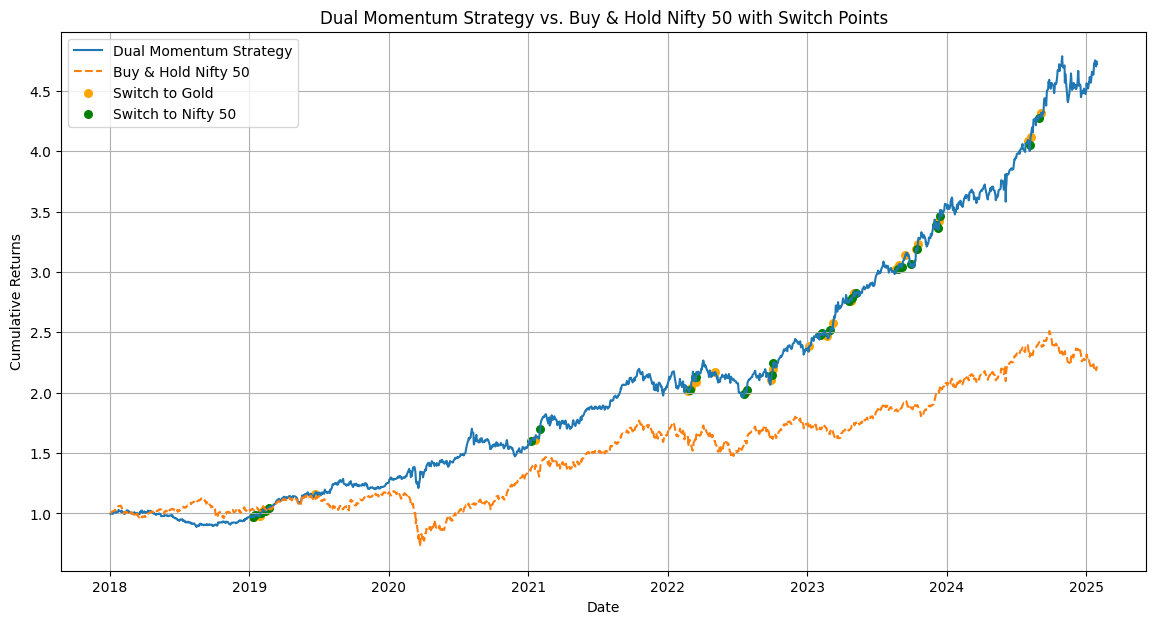

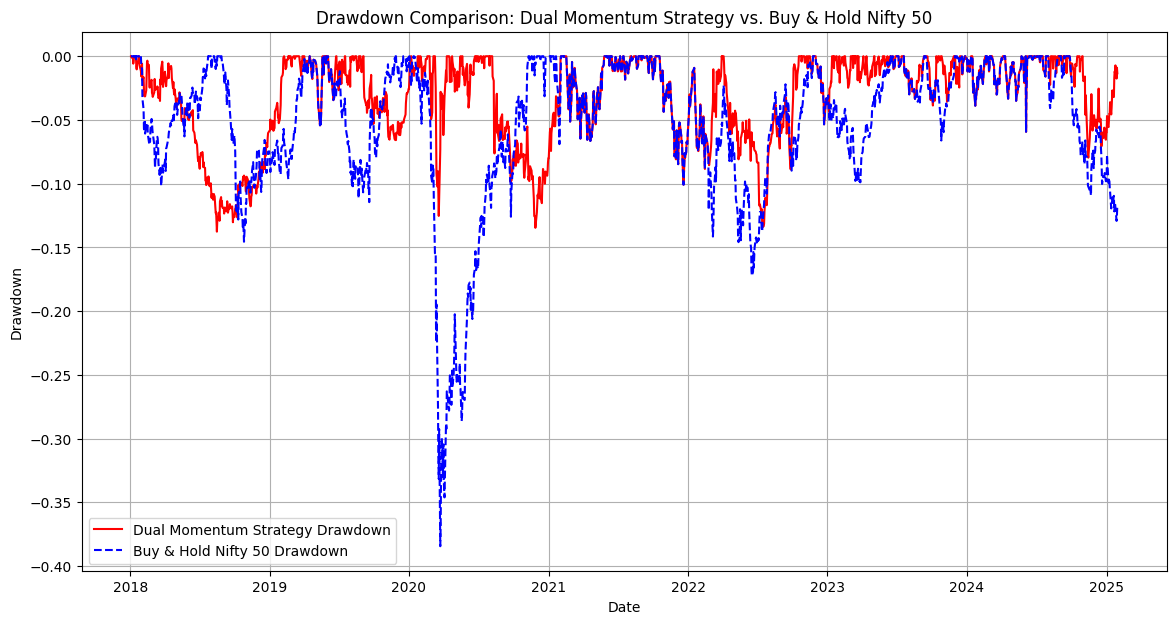

Max Drawdown of Dual Momentum Strategy: -13.76%
Max Drawdown of Buy & Hold Nifty 50 Strategy: -38.44%


In [29]:
# Plot the equity curves with switch points
plt.figure(figsize=(14, 7))
plt.plot(nifty50_data['Strategy_Equity_Curve'], label='Dual Momentum Strategy')
plt.plot(nifty50_data['Buy_Hold_Equity_Curve'], label='Buy & Hold Nifty 50', linestyle='--')

# Plot switch points
switch_from_nifty_to_gold = (nifty50_data['Signal'].diff() < 0) & switch_points
switch_from_gold_to_nifty = (nifty50_data['Signal'].diff() > 0) & switch_points

plt.scatter(nifty50_data.index[switch_from_nifty_to_gold], 
            nifty50_data['Strategy_Equity_Curve'][switch_from_nifty_to_gold], 
            color='orange', label='Switch to Gold', marker='o', s=30)

plt.scatter(nifty50_data.index[switch_from_gold_to_nifty], 
            nifty50_data['Strategy_Equity_Curve'][switch_from_gold_to_nifty], 
            color='green', label='Switch to Nifty 50', marker='o', s=30)

plt.title('Dual Momentum Strategy vs. Buy & Hold Nifty 50 with Switch Points')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Drawdowns
plt.figure(figsize=(14, 7))
plt.plot(nifty50_data['Strategy_Drawdown'], label='Dual Momentum Strategy Drawdown', color='red')
plt.plot(nifty50_data['Buy_Hold_Drawdown'], label='Buy & Hold Nifty 50 Drawdown', color='blue', linestyle='--')
plt.title('Drawdown Comparison: Dual Momentum Strategy vs. Buy & Hold Nifty 50')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Print max drawdowns
max_strategy_drawdown = nifty50_data['Strategy_Drawdown'].min()
max_buy_hold_drawdown = nifty50_data['Buy_Hold_Drawdown'].min()

print(f"Max Drawdown of Dual Momentum Strategy: {max_strategy_drawdown:.2%}")
print(f"Max Drawdown of Buy & Hold Nifty 50 Strategy: {max_buy_hold_drawdown:.2%}")

Conclusion

The Dual Momentum Strategy by Gary Antonacci is a powerful yet straightforward approach to investing, combining the benefits of both relative and absolute momentum. Through the implementation and backtesting in Python, we see how this strategy can potentially enhance returns while minimizing risks. However, like all strategies, it’s important to remember that past performance does not guarantee future results, and investors should consider their risk tolerance and investment goals before implementing any strategy.

By incorporating momentum investing principles into your portfolio, the Dual Momentum Strategy can serve as a valuable tool in the quest for long-term financial growth and stability